In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

from scipy import stats as st
import numpy as np

In [2]:
calls=pd.read_csv('/datasets/calls.csv')
internet=pd.read_csv('/datasets/internet.csv')
messages=pd.read_csv('/datasets/messages.csv')
tariffs=pd.read_csv('/datasets/tariffs.csv')
users=pd.read_csv('/datasets/users.csv')

### Подготовка данных

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В таблице "Звонки" у нас есть нулевые звонки - по условию задачи это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.
переведем столбец "call_date" к типу дата

нам нужно округлить данные по звонкам до целых значений в соответствии с тарифными  условиями

In [5]:
calls['call_date']=pd.to_datetime(calls['call_date'])
calls['duration'] = np.ceil(calls['duration'])
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


In [6]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [8]:
internet['session_date']=pd.to_datetime(internet['session_date'])

In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [10]:
messages['message_date']=pd.to_datetime(messages['message_date'])

In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [12]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [14]:
internet['mb_used'].sort_values()




116616       0.00
53410        0.00
104303       0.00
19438        0.00
19437        0.00
           ...   
140299    1623.92
103480    1651.25
7063      1651.55
119156    1702.75
137493    1724.83
Name: mb_used, Length: 149396, dtype: float64

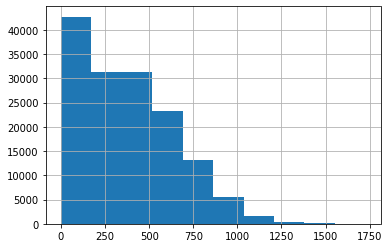

In [15]:
internet['mb_used'].hist(bins=10)

мы видим аномилию по 0 трафику интернета. Распределение не похоже на нормальное. Возможно эта аномилия, а возмонжо что это пользователи, которые не смогли войти в сеть (неудачные попытки)  Такое тоже возможно. 

Далее необъодимо сформировать общий датасет. Смерджить все( 
Попробуем такую логику: 
сгруппируем таблицы calls, internet и messages по id пользователя и месяцу 

потом объединим их между собой и таблицами users и tariffs

In [16]:
calls['month']=pd.DatetimeIndex(calls['call_date']).month

In [17]:
calls=calls.groupby(['user_id', 'month']).agg({'duration': 'sum'}).reset_index()
calls.head()

,user_id,month,duration
0,1000,5,159.0
1,1000,6,172.0
2,1000,7,340.0
3,1000,8,408.0
4,1000,9,466.0


In [18]:
internet['month']=pd.DatetimeIndex(internet['session_date']).month


internet=internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()


In [19]:
internet.head(10)

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
5,1000,10,14702.49
6,1000,11,14756.47
7,1000,12,9817.61
8,1001,11,18429.34
9,1001,12,14036.66


In [20]:
messages['month']=pd.DatetimeIndex(messages['message_date']).month

In [21]:

messages=messages.groupby(['user_id', 'month']).agg({'id': 'count'}).reset_index()


In [22]:
messages.head()

,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [23]:
calls.head(10)

,user_id,month,duration
0,1000,5,159.0
1,1000,6,172.0
2,1000,7,340.0
3,1000,8,408.0
4,1000,9,466.0
5,1000,10,350.0
6,1000,11,338.0
7,1000,12,333.0
8,1001,11,430.0
9,1001,12,414.0


In [24]:
data= calls.merge(messages, on =['user_id','month'], how = 'outer')
data=data.merge(internet, on =['user_id','month'], how = 'outer')

data=data.merge(calls, on =['user_id','month'], how = 'outer')
data=data.rename(columns={'user_id': 'user_id','month':'month', 'duration_x':'duration_call', 'id': 'messages', 'mb_used':'mb_used', 'duration_y':'duration_y'})

In [25]:
data['duration_call'].sum()

1450301.0

In [26]:
calls['duration'].sum()

1450301.0

Вывод: данные после объединения не потерляись) 

In [27]:
data=data.merge(users, on =['user_id'], how = 'outer')
data=data.rename(columns={'tariff': 'tariff_name'})
data=data.merge(tariffs, on =['tariff_name'], how = 'outer')
data.reset_index()

,index,user_id,month,duration_call,messages,mb_used,duration_y,age,churn_date,city,...,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,0,1000,5.0,159.0,22.0,2253.49,159.0,52,NaN,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1,1000,6.0,172.0,60.0,23233.77,172.0,52,NaN,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,2,1000,7.0,340.0,75.0,14003.64,340.0,52,NaN,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,3,1000,8.0,408.0,81.0,14055.93,408.0,52,NaN,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,4,1000,9.0,466.0,57.0,14568.91,466.0,52,NaN,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,3211,1489,9.0,NaN,32.0,17206.30,NaN,35,NaN,Санкт-Петербург,...,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3212,3212,1489,10.0,NaN,21.0,19559.44,NaN,35,NaN,Санкт-Петербург,...,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3213,3213,1489,11.0,NaN,20.0,17491.56,NaN,35,NaN,Санкт-Петербург,...,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3214,3214,1489,12.0,NaN,35.0,17322.51,NaN,35,NaN,Санкт-Петербург,...,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3


In [28]:
#код ревьюера
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 20 columns):
user_id                  3216 non-null int64
month                    3214 non-null float64
duration_call            3174 non-null float64
messages                 2717 non-null float64
mb_used                  3203 non-null float64
duration_y               3174 non-null float64
age                      3216 non-null int64
churn_date               189 non-null object
city                     3216 non-null object
first_name               3216 non-null object
last_name                3216 non-null object
reg_date                 3216 non-null object
tariff_name              3216 non-null object
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute         

 ### Предварительные расчеты

Посчитайте для каждого пользователя:
количество сделанных звонков и израсходованных минут разговора по месяцам;
количество отправленных сообщений по месяцам;
объем израсходованного интернет-трафика по месяцам; - похоже я уже это посчитала через группировку. 


помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

почитаем дельту между данными. обнулим с помощью loc отрицательные значения на нули и затем почитаем выручку



In [29]:
data=data.fillna(0)

data['delta_duration'] = data['duration_call']-data['minutes_included']
data['delta_mb'] = data['mb_used']-data['mb_per_month_included']
data['delta_messages'] = data['messages']-data['messages_included']


In [30]:


data.loc[data['delta_duration']<0,'delta_duration'] =0
data.loc[data['delta_mb']<0,'delta_mb'] =0
data.loc[data['delta_messages']<0,'delta_messages'] =0
data['delta_gb'] = np.ceil(data['delta_mb']/1024)
data['delta_duration'].fillna(0)
data['delta_mb'].fillna(0)
data['delta_messages'].fillna(0)

data['duration_call']=data['duration_call'].fillna(0)
data['mb_used']=data['mb_used'].fillna(0)
data['messages'] = data['messages'].fillna(0)



data['revenue'] = data['rub_monthly_fee'] + data['delta_duration']* data['rub_per_minute']+ data['delta_gb']* data['rub_per_gb']

In [31]:
data.head(10)

,user_id,month,duration_call,messages,mb_used,duration_y,age,churn_date,city,first_name,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,delta_duration,delta_mb,delta_messages,delta_gb,revenue
0,1000,5.0,159.0,22.0,2253.49,159.0,52,0,Краснодар,Рафаил,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
1,1000,6.0,172.0,60.0,23233.77,172.0,52,0,Краснодар,Рафаил,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
2,1000,7.0,340.0,75.0,14003.64,340.0,52,0,Краснодар,Рафаил,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
3,1000,8.0,408.0,81.0,14055.93,408.0,52,0,Краснодар,Рафаил,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
4,1000,9.0,466.0,57.0,14568.91,466.0,52,0,Краснодар,Рафаил,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
5,1000,10.0,350.0,73.0,14702.49,350.0,52,0,Краснодар,Рафаил,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
6,1000,11.0,338.0,58.0,14756.47,338.0,52,0,Краснодар,Рафаил,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
7,1000,12.0,333.0,70.0,9817.61,333.0,52,0,Краснодар,Рафаил,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
8,1003,8.0,380.0,37.0,8565.21,380.0,23,0,Москва,Белла,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
9,1003,9.0,961.0,91.0,12468.87,961.0,23,0,Москва,Белла,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0


In [32]:
data['revenue'].isnull().sum()

0

# Шаг 3. Проанализируйте данные


Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.


## Тариф Смарт

In [33]:
data_smart = data.query('tariff_name == "smart"')
data_smart_pivot = data_smart.pivot_table(
index=['user_id'],
values=['duration_call','messages','mb_used'],
aggfunc='mean')

data_smart_pivot


,duration_call,mb_used,messages
user_id,,,
1001,422.000000,16233.000000,0.0
1002,216.714286,16576.645714,10.0
1005,550.416667,8307.275833,46.0
1006,318.272727,14926.255455,0.0
1007,486.555556,14625.074444,25.0
...,...,...,...
1494,389.200000,15398.832000,0.0
1496,498.666667,22578.524167,39.0
1497,468.666667,15191.656667,17.0


<div class="alert alert-block alert-info">
<b>Комментарий студента: получили базовую таблицу с распределением длительности звонков, МБ и сообщений. Далее будем исследовать распределение этих данных</b> 

### Исследуем длительность  звонка

In [34]:

variance_estimate = np.var(data_smart_pivot['duration_call'], ddof=1)
variance_estimate

21475.741546069516

In [35]:
mean_value = data_smart_pivot['duration_call'].mean()
mean_value

418.43926217815107

In [36]:
standard_deviation = np.std(data_smart_pivot['duration_call'])
standard_deviation

146.3371350588097

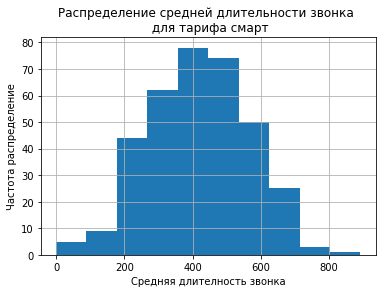

In [37]:
data_smart_pivot['duration_call'].hist(bins=10)

plt.xlabel('Средняя длителность звонка')
plt.ylabel('Частота распределение')
plt.title('Распределение средней длительности звонка \n для тарифа смарт')
plt.show()


Вывод: распределение средней длителности звонка для тарифа смарт имеет нормальное распредление
Выборка распределена нормально вокруг среднего в 420 минут с разбросом значений 143 минуты 

### Исследуем количество сообщений

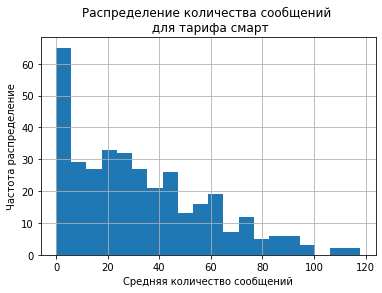

In [38]:
data_smart_pivot['messages'].hist(bins=20)

plt.xlabel('Средняя количество сообщений')
plt.ylabel('Частота распределение')
plt.title('Распределение количества сообщений \n для тарифа смарт')
plt.show()

In [39]:


variance_estimate = np.var(data_smart_pivot['messages'], ddof=1)
variance_estimate

703.8835242898488

In [40]:
mean_value = data_smart_pivot['messages'].mean()
mean_value

32.2599070682404

In [41]:
standard_deviation = np.std(data_smart_pivot['messages'])
standard_deviation

26.492983186568114

Вывод: Количество сообщений имюет среднее занчение 37 со станартным отклонением в 24 сообщения и имеют сконегглсть вправо. 
Значнеие разброса близко в среднему , распределение не однородное по значениям

### Исследуем интернет трафик

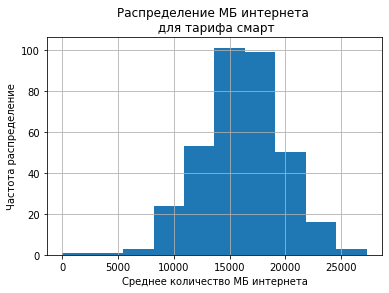

In [42]:
data_smart_pivot['mb_used'].hist(bins=10)

plt.xlabel('Среднее количество МБ интернета')
plt.ylabel('Частота распределение')
plt.title('Распределение МБ интернета \n для тарифа смарт')
plt.show()

In [43]:
variance_estimate = np.var(data_smart_pivot['mb_used'], ddof=1)
variance_estimate

13520127.156128755

In [44]:
mean_value = data_smart_pivot['mb_used'].mean()
mean_value

16134.51535294438

In [45]:
standard_deviation = np.std(data_smart_pivot['mb_used'])
standard_deviation

3671.7309644556017

Вывод: 
выборка распрделения использованных ГБ интернета имеет норсальное распределение, со средним в 16 ГБ и разбросом даннвх в 3,57 ГБ 

## Тариф Ультра

In [46]:
data_ultra = data.query('tariff_name == "ultra"')
data_ultra_pivot = data_ultra.pivot_table(
index=['user_id'],
values=['duration_call','messages','mb_used'],
aggfunc='mean')

data_ultra_pivot

,duration_call,mb_used,messages
user_id,,,
1000,320.750000,13424.038750,62.0
1003,764.400000,11456.128000,76.0
1004,123.375000,18629.935000,149.0
1013,468.000000,15258.580000,21.0
1016,61.000000,13405.220000,71.0
...,...,...,...
1476,467.111111,16698.434444,5.0
1485,584.000000,23422.760000,155.0
1491,513.333333,17940.248889,48.0


### Исследуем длительность звонка


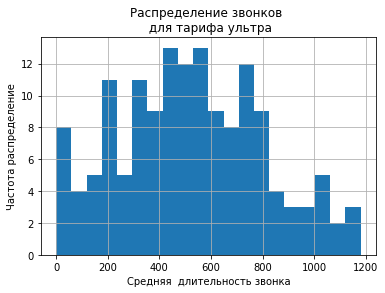

In [47]:
data_ultra_pivot['duration_call'].hist(bins=20)

plt.xlabel('Средняя  длительность звонка')
plt.ylabel('Частота распределение')
plt.title('Распределение звонков \n для тарифа ультра')
plt.show()

In [48]:
variance_estimate = np.var(data_ultra_pivot['duration_call'], ddof=1)
variance_estimate

80736.81232424302

In [49]:
mean_value = data_ultra_pivot['duration_call'].mean()
mean_value

524.279390985599

In [50]:
standard_deviation = np.std(data_ultra_pivot['duration_call'])
standard_deviation

283.18713693141

Вывод: распределение средней длительности звонка не походе на нормальное. Явно видны выброса данных 

Среднее значение по выборке 546 минут с разбросом в 267 минут

Это оченб большо разброс данных. 

In [51]:
### Исследуем количество сообщений


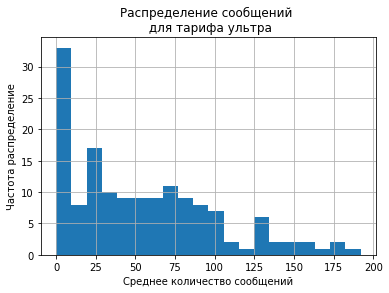

In [52]:
data_ultra_pivot['messages'].hist(bins=20)

plt.xlabel('Среднее количество сообщений')
plt.ylabel('Частота распределение')
plt.title('Распределение сообщений \n для тарифа ультра')
plt.show()

In [53]:
variance_estimate = np.var(data_ultra_pivot['messages'], ddof=1)
variance_estimate

2154.8956829312533

In [54]:
mean_value = data_ultra_pivot['messages'].mean()
mean_value

53.66812080536913

In [55]:
standard_deviation = np.std(data_ultra_pivot['messages'])
standard_deviation

46.26481704057076

Вывод: данные имеют много выбросов 

среднее 64 и разбром 43. 
Это не нормальное распределение; 

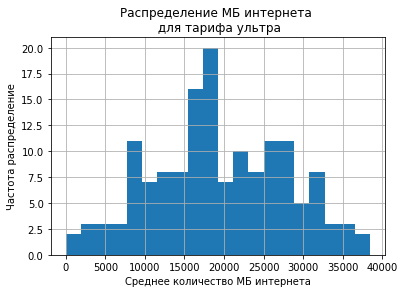

In [56]:
data_ultra_pivot['mb_used'].hist(bins=20)

plt.xlabel('Среднее количество МБ интернета')
plt.ylabel('Частота распределение')
plt.title('Распределение МБ интернета \n для тарифа ультра')
plt.show()

In [57]:
variance_estimate = np.var(data_ultra_pivot['mb_used'], ddof=1)
variance_estimate

71180608.84282224

In [58]:
mean_value = data_ultra_pivot['mb_used'].mean()
mean_value

19443.27113495695

In [59]:
standard_deviation = np.std(data_ultra_pivot['mb_used'])
standard_deviation

8408.500855433353

In [60]:
data.head(1)

,user_id,month,duration_call,messages,mb_used,duration_y,age,churn_date,city,first_name,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,delta_duration,delta_mb,delta_messages,delta_gb,revenue
0,1000,5.0,159.0,22.0,2253.49,159.0,52,0,Краснодар,Рафаил,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0


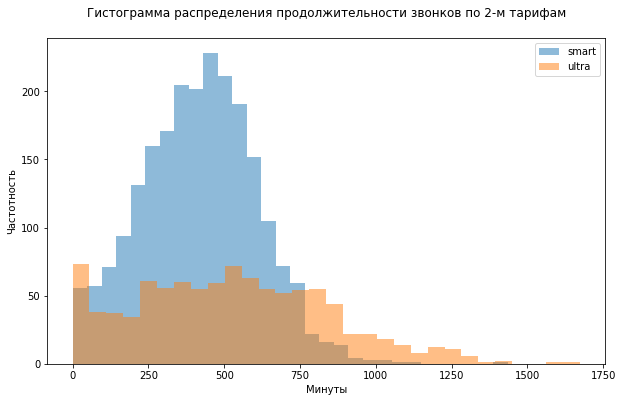

In [61]:
from matplotlib import pyplot as plt



plt.figure(figsize=(10, 6))
data['duration_call'][data['tariff_name'] == 'smart'].plot(kind='hist', alpha=0.5, bins=30)
data['duration_call'][data['tariff_name'] == 'ultra'].plot(kind='hist', alpha=0.5, bins=30)
plt.title('Гистограмма распределения продолжительности звонков по 2-м тарифам'+ "\n")
plt.xlabel('Минуты')
plt.ylabel('Частотность')
plt.legend(['smart', 'ultra'])

plt.show()

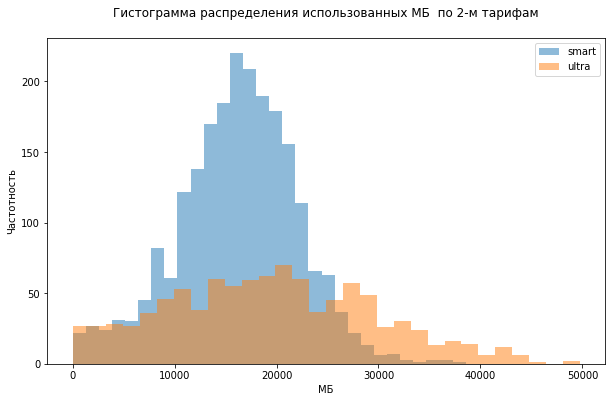

In [62]:
plt.figure(figsize=(10, 6))
data['mb_used'][data['tariff_name'] == 'smart'].plot(kind='hist', alpha=0.5, bins=30)
data['mb_used'][data['tariff_name'] == 'ultra'].plot(kind='hist', alpha=0.5, bins=30)
plt.title('Гистограмма распределения использованных МБ  по 2-м тарифам'+ "\n")
plt.xlabel('МБ')
plt.ylabel('Частотность')
plt.legend(['smart', 'ultra'])

plt.show()

<div class="alert alert-block alert-info">
<b>Комментарий студента:
    
    вывод такой: распределение используемых МБ интернета по тарифу ультра имеет больше размах данных. В Тарифк Смарт распределение потребления болльше похоже на нормальное и однородное
        
        то же касается и звонков </b> 

## Шаг 4. Проверьте гипотезы
средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
Пороговое значение alpha задайте самостоятельно.
Поясните:
как вы формулировали нулевую и альтернативную гипотезы;
какой критерий использовали для проверки гипотез и почему.

### Гипотеза средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

Нулевая гипотеза: средняя выручка пользователей по тарифам равна"

    
Альтернативная гипотеза: средняя выручка пользователей  тарифа смарт меньше средней выручки по тарифу ультра
    
Выбрала односторонюю гипотезу, так как нам важно понять, какой тариф больше или меньше приносит денег 



In [63]:


sample_1 = data_smart['revenue']
sample_2 = data_ultra['revenue']

alpha = .05

mean_ultra  = data_ultra['revenue'].mean()
mean_ultra

2070.030425963489

In [69]:

results = st.ttest_1samp(
    sample_1, 
    mean_ultra)

alpha = .05

print('p-значение: ', results.pvalue/2)

if (results.pvalue / 2 < alpha) and (sample_1.mean() < mean_ultra):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу") 


p-значение:  8.502007597493774e-56
Отвергаем нулевую гипотезу


Вывод: средняя выручка пользователей  тарифа смарт меньше средней выручки по тарифу ультра.  Проверено тестом

Проверка гипотезы: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. 

Нулевая гипотеза: выручка пользователей из Москвы равна выручке из других городов

Альтернативная гипотеза: выручка пользователей из Москвы  отличается от выручки по другим городам

In [70]:
test1=data.query('city == "Москва"')
test2 = data.query('city != "Москва"')

sample_1 = test1['revenue']
sample_2 = test2['revenue']

alpha = .05

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
    


p-значение:  0.44244349299632846
Не получилось отвергнуть нулевую гипотезу


<div class="alert alert-block alert-info">
<b>Комментарий студента: Выручка пользователей из Москвы все же равна выручке пользвоателей из других гороов. </b> 



<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 



# Общий вывод:
    
Мы изучали данные о пользователях и тарифах на небольших выборках.
    
----
    
В рамках работы были произведены подготовительные этапы:
Приведение столбцов к формату дат
Округление в соответствии с условиями задачи
Расчет показателей выручки по пользователям

## Проанализировали отдельно распределение данных по тарифам

----
    
### СМАРТ:

* Среднее по длительности звонков в месяц 420 минут с разбросом значений в 143 минуты (в обе стороны).
По тарифу включено 550 минут. 
Таким образом, можно говорить о том, что в среднем пользователи не успевают потратить все минуты тарифа за месяц. 

*  По количеству сообщений среднее значение 37 шт с отклонением в 24 сообщения. Распределение не нормальное. Большая доля пользователей с количество сообщений менее 10.
По тарифу включено 50 бесплатных сообщений.
*  Не большая часть пользователей выходит за эти пределы. Можно посчитать долю через перцентили (но это в след уроках)))


*  Интернет 
Можно говорить о том, что в среднем пользователи выходят за бесплатный лимит в 15 ГБ (среднее 16 134 МБ - рано 15, 7 ГБ) , и достаточно большой разброс данных вокруг среднего в 3,5 ГБ 
    
**Таким образом, можно говорить о том, что по тарифу СМАРТ пользователи в основном докупают  интернет  в размере 1-4 ГБ (по цене 150 р за ГБ)**
    
    
----
    

### УЛЬТРА 

* Длительность звонка: 

Среднее значение по выборке 546 минут с разбросом в 267 минут
Распределение не нормальное, много выбросов
По тарифу включено 3000 минут разговора, и можно говорить о том, что пользователи не «выговаривают» этот тариф. То же и про сообщения

* С интернет трафиком ситуация отличается,
Можно говорить о среднем потреблении примерно 19 ГБ интернета со средним разбросом в  8 ГБ 
Однако выше 30 ГБ  - выше тарифа достаточно мало значений.

----

**По проверенным гипотезам можно сделать вывод о том, что средняя выручка по тарифам различается. Средняя выручка по тарифу Смарт меньше чем по тарифу Ультра.** 
И мы знаем, что выручка по Москве примерно равна сумме выручки по другим городам 

**Итого, мы можем  рекомендовать коммерческому департаменту корректировать рекламный бюджет в пользу тарифа ультра.**


</div>

<font color='blue'>




